# Pytorch ONNX ONNXRuntime

ONNX (Open Neural Network Exchange) and ONNX Runtime are two related but distinct components in the machine learning ecosystem. Here's a brief overview of each:

1) **ONNX (Open Neural Network Exchange):**

- ONNX is an open format for machine learning models. It defines an IR (Intermediate Representation) of the model, along with an extensible computation graph model, built-in operators, and standard data types.

- The primary goal of ONNX is to enable the transfer of models between different frameworks, runtimes, and compilers. For example, you can train a model in PyTorch, convert it to ONNX format, and then use another framework or runtime to perform inference.

- ONNX is developed and maintained by the ONNX community, which includes partners like AWS, Facebook, and Microsoft.

2) **ONNX Runtime**:

- ONNX Runtime is a performance-focused scoring engine for ONNX models. It's designed to accelerate machine learning inferencing across a variety of platforms and hardware configurations.

- It supports both cloud and edge environments and is optimized for both CPU and GPU hardware.

- ONNX Runtime is open-source and is developed and maintained by Microsoft. It supports models from many popular frameworks via ONNX, including PyTorch, TensorFlow, and scikit-learn.
- Some of the key features of ONNX Runtime include:
    Cross-platform support (Windows, Linux, and MacOS)
    Optimized performance for both CPU and GPU
    Support for model quantization and other optimizations
    Easy-to-use APIs for different languages like Python, C++, and C#


In summary, ONNX is a format for representing machine learning models, while ONNX Runtime is a tool for running and optimizing those models. They work together to enable efficient and flexible machine learning workflows.

For example take a simple model for classifaction Iris Dataset

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
plt.style.use('ggplot')

# Load Data

In [2]:
iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']


# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

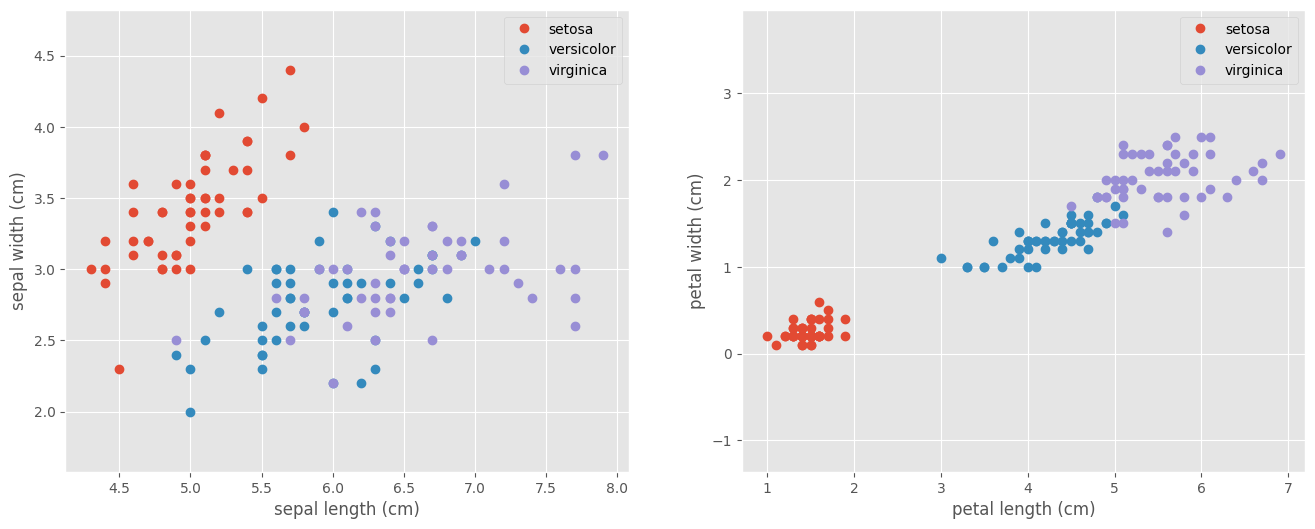

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax1.plot(X_plot[:, 0], X_plot[:, 1], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax1.set_xlabel(feature_names[0])
ax1.set_ylabel(feature_names[1])
ax1.axis('equal')
ax1.legend();

for target, target_name in enumerate(names):
    X_plot = X[y == target]
    ax2.plot(X_plot[:, 2], X_plot[:, 3], 
             linestyle='none', 
             marker='o', 
             label=target_name)
ax2.set_xlabel(feature_names[2])
ax2.set_ylabel(feature_names[3])
ax2.axis('equal')
ax2.legend();

# Configure Neural Network Models

In [4]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

In [5]:
class Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [6]:
torch_model     = Model(X_train.shape[1], len(np.unique(y_train)))
optimizer = torch.optim.Adam(torch_model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
torch_model

Model(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=3, bias=True)
)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch_model = torch_model.to(device)
torch_model

Model(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=3, bias=True)
)

# Training model

In [8]:
X_train = torch.from_numpy(X_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.long)
y_test = torch.from_numpy(y_test).type(torch.long)


In [9]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [10]:
from tqdm import tqdm

EPOCHS  = 100


loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm(range(EPOCHS)):
    y_pred = torch_model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = torch_model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 100/100 [00:00<00:00, 285.01it/s]


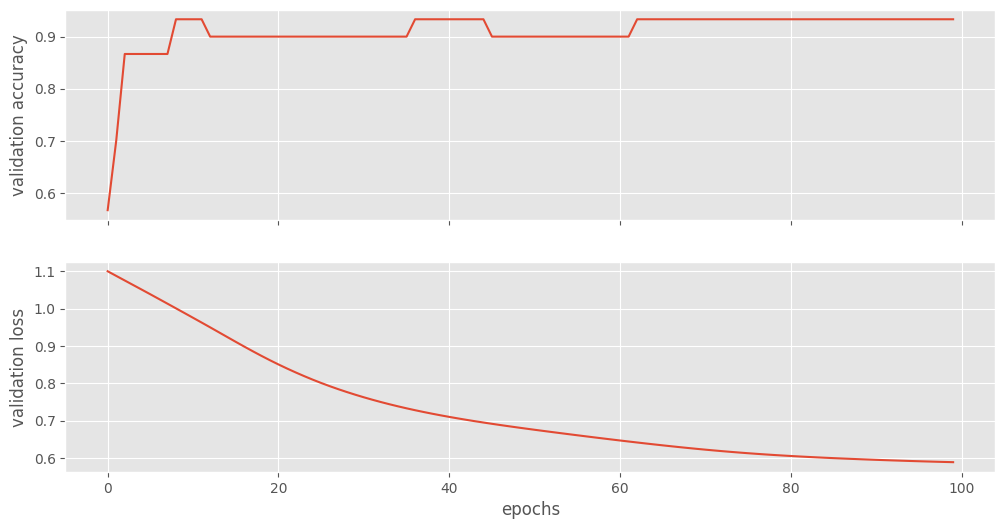

In [11]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");

# Export model to onnx 


In [12]:
# set the model to inference mode
torch_model.eval()

Model(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=3, bias=True)
)

In [13]:
# Export the model
x = torch.randn(1,4).to(device)
torch_out = torch_model(x)

In [18]:

#Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "../models/torch_onnx.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                 )


In [19]:
import onnx

onnx_model = onnx.load("../models/torch_onnx.onnx")
onnx.checker.check_model(onnx_model)

In [23]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession("../models/torch_onnx.onnx",  providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")


Exported model has been tested with ONNXRuntime, and the result looks good!


# Timing Comparison Between Models

In [50]:
import time

x = torch.randn(1, 4, requires_grad=True)

start = time.time()
torch_out = torch_model(x)
end = time.time()
print(f"Inference of Pytorch model used {end - start} seconds")

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
start = time.time()
ort_outs = ort_session.run(None, ort_inputs)
end = time.time()
print(f"Inference of ONNX model used {end - start} seconds")

Inference of Pytorch model used 0.0010361671447753906 seconds
Inference of ONNX model used 0.0009655952453613281 seconds


In [52]:
ort_outs

[array([[0.00130914, 0.9646763 , 0.03401457]], dtype=float32)]

In [34]:
torch_out

tensor([[3.3143e-05, 3.5763e-03, 9.9639e-01]], grad_fn=<SoftmaxBackward0>)

How can we see model outputs has the similar results, and onnx model has more faster inference